# Essential packages and imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

# Accessing dataset directory

In [48]:
train_dir = '/kaggle/input/pneumonia-detection-dataset/train'
val_dir = '/kaggle/input/pneumonia-detection-dataset/val'
test_dir = '/kaggle/input/pneumonia-detection-dataset/test'

# Loading image data with data generator

In [49]:
datagenerator = ImageDataGenerator(
    rescale=1 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

test_datagenerator = ImageDataGenerator(rescale=1 / 255)

img_size = 150
batch_size = 16

In [50]:
def create_data_generator(directory, batch_size, color_mode='grayscale', class_mode='binary', shuffle=True):
    return ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle
    )

train_generator = create_data_generator(train_dir, batch_size)
val_generator = create_data_generator(val_dir, batch_size)
test_generator = create_data_generator(test_dir, batch_size, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Class labeling and sample data

In [51]:
class_labels = [label for label, _ in train_generator.class_indices.items()]
num_classes = len(class_labels)
class_labels

['NORMAL', 'PNEUMONIA']

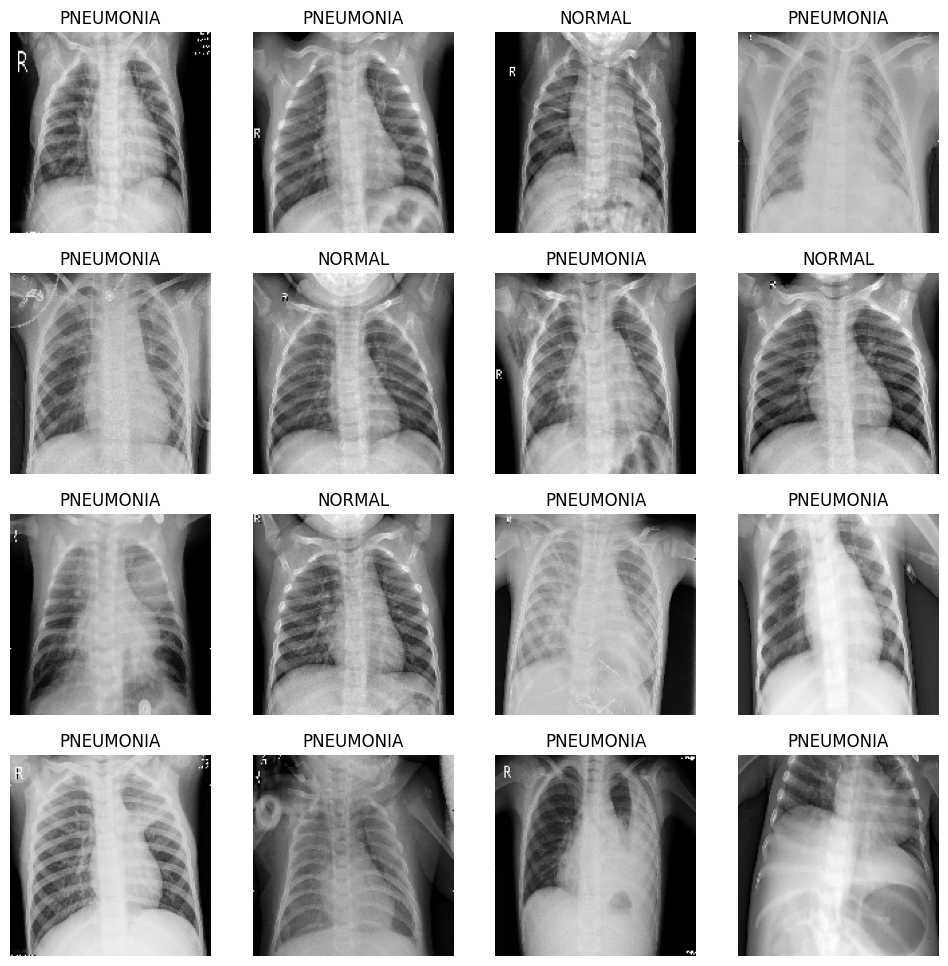

In [52]:
sample_images, labels = next(train_generator)
labels_int = labels.astype(int)

plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_images[i],cmap='gray')
    plt.title(class_labels[labels_int[i]])
    plt.axis('off')
plt.show()

# Class distributions in datasets

In [53]:
def plot_class_distribution(generator, dataset):
    num_samples = len(generator.filenames)
    class_distribution = np.unique(generator.classes, return_counts=True)
    classes, counts = class_distribution

    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'Class Distribution - {dataset} Data')
    plt.show()

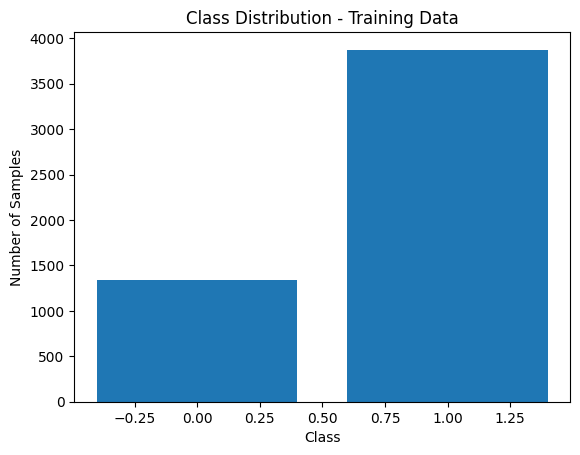

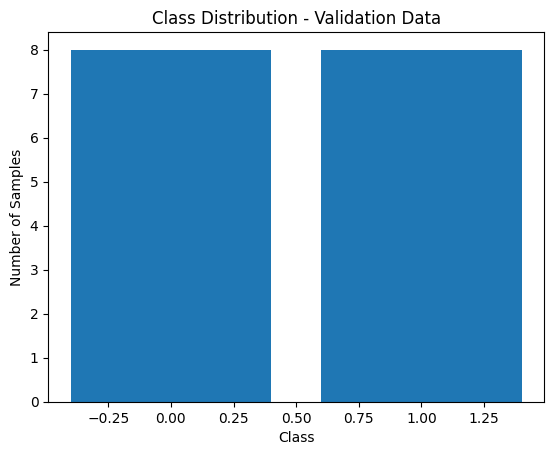

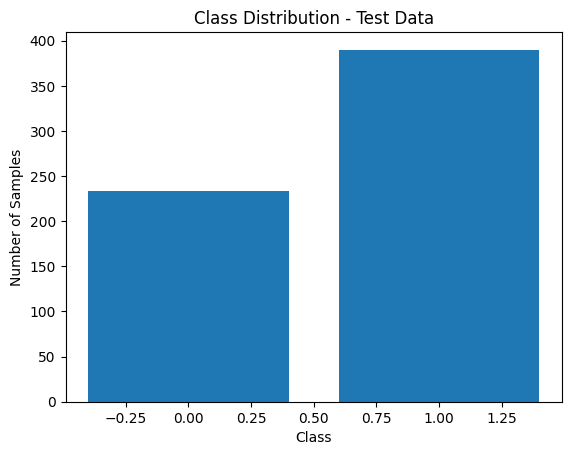

In [54]:

plot_class_distribution(train_generator, 'Training')

plot_class_distribution(val_generator, 'Validation')

plot_class_distribution(test_generator, 'Test')

# Model Architecture & Training

In [63]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Flatten(),

    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_21 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_22 (Ba  (None, 75, 75, 64)       

In [64]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


2024-01-20 16:41:48.021547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


326/326 [==============================] - 37s 98ms/step - loss: 0.2295 - accuracy: 0.9270 - val_loss: 18.5030 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - 32s 97ms/step - loss: 0.1001 - accuracy: 0.9636 - val_loss: 6.2236 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9697
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 32s 98ms/step - loss: 0.0825 - accuracy: 0.9697 - val_loss: 0.9065 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 32s 98ms/step - loss: 0.0545 - accuracy: 0.9812 - val_loss: 2.2758 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
326/326 [==============================] - 32s 98ms/step - loss: 0.0422 - accuracy: 0.9858 - val_loss: 0.1309 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 6/10
326/326 [==============================] - 32

## Training Result

<Axes: >

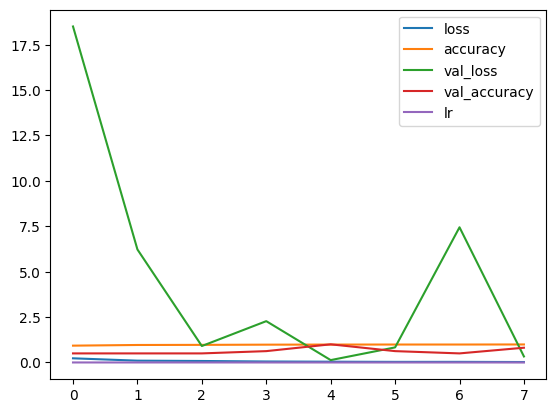

In [65]:
pd.DataFrame(history.history).plot()

# Testing Model 

In [66]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int)

true_labels = test_generator.classes

print(classification_report(true_labels, predicted_labels))

39/39 [==============================] - 4s 92ms/step
              precision    recall  f1-score   support

           0       1.00      0.26      0.42       234
           1       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.85      0.63      0.62       624
weighted avg       0.81      0.72      0.67       624



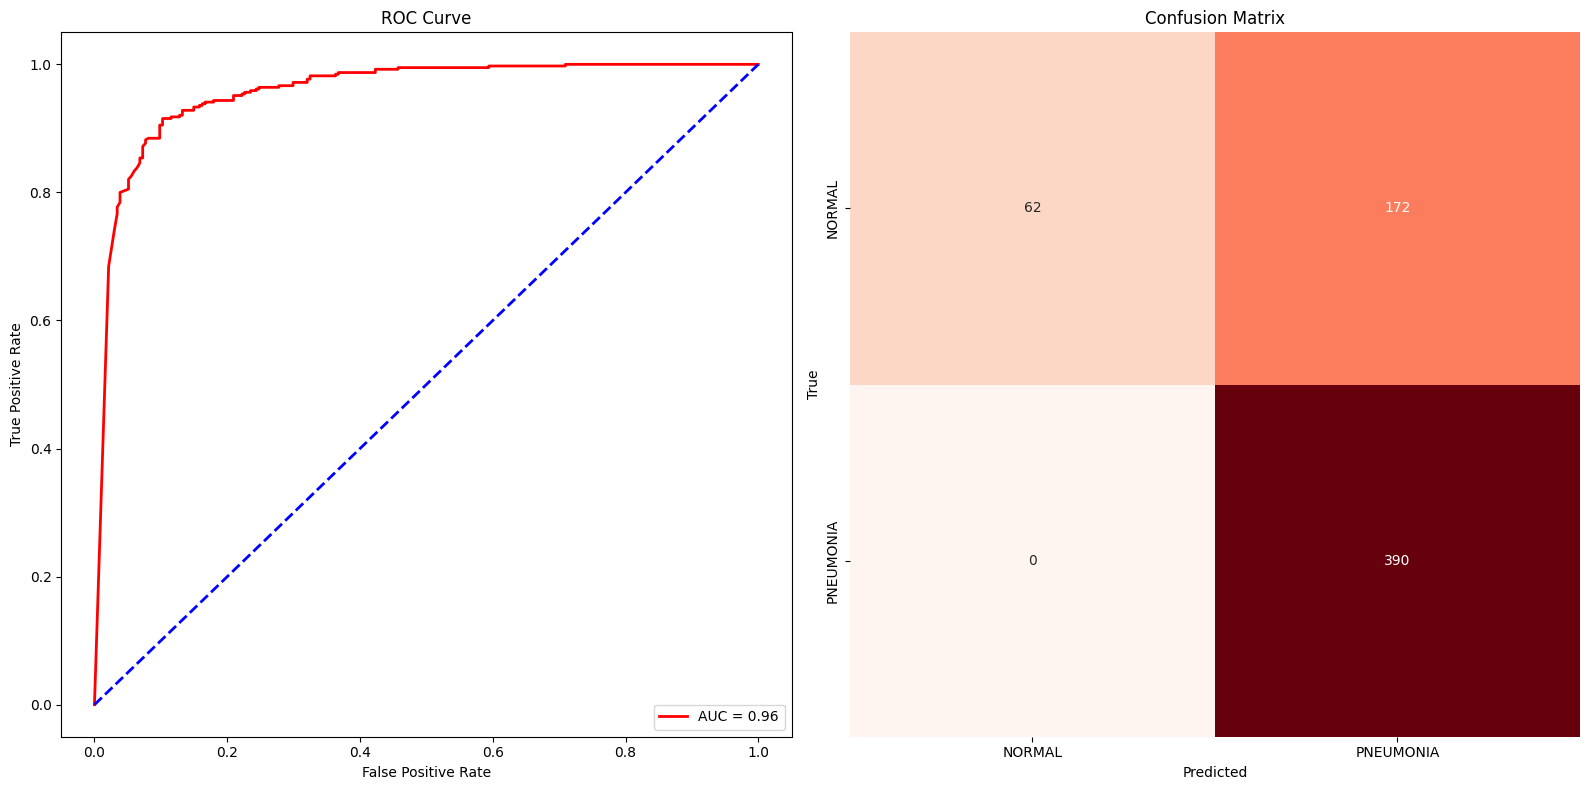

In [67]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='red', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()